#Chapter 05: Linear Systems: Direct Methods

In [78]:
using PyPlot

The following functions are helper functions for the coding examples in Chapter 5

In [79]:
function forsub(A,b,p)
    # Given a unit lower triangular, nonsingular n by n 
    # matrix A, an n-vector b, and a permutation p,
    # return vector y which solves Ay = Pb
    
    n = length(b)
    
    #permute b according to p
    permute!(b,vec(p))
    
    #forward substitution
    y = copy(b)
    for k = 2:n
        multval = A[k,1:k-1]*y[1:k-1]
        y[k] = b[k] - multval[1]
    end
    
    return y
end

function backsub(A,b)
    # Given an upper triangular, nonsingular n by n matrix A
    # and an n-vector b, return vector x which solves Ax = b
    
    n = length(b)
    x = b
    x[n] = b[n]/A[n,n]
    for k = n-1:-1:1
        multval = 0
        for i = k+1:n
            multval = multval + A[k,i]*x[i]
        end
        x[k] = (b[k] - multval) / A[k,k]
    end
    return x
end

function plu(A)
    # Perform LU decomposition with partial pivoting.
    # Upon return the coefficients of L and U replace those
    # of the input n-by-n nonsingular matrix A. The row interchanges
    # performed are recorded in the 1D array p (returned).
   
    n = size(A,1)
    
    # initialize permutation vector p
    p = collect(1:n)
    
    #LU decomposition with partial pivoting
    for k = 1:n-1
        hMat = copy(A)
        for i = 1:size(A,1)
            for j = 1:size(A,2)
                if hMat[i,j] <0
                    hMat[i,j] = -hMat[i,j]
                end
            end
        end
        
        #Find row index of relative maximum in column k
        val,q = findmax((hMat[k:n,k]))
        q = q + k-1
        
        #Interchange rows k and q and record this in p
        A[k,:],A[q,:] = A[q,:],A[k,:]
        p[k],p[q] = p[q],p[k]
        
        #Compute the corresponding column of L
        J = k+1:n
        A[J,k] = A[J,k] / A[k,k]
        
        #Update submatrix by outer product
        A[J,J] = A[J,J] - A[J,k] * A[k,J]
    end
    return p,A
end

function plu_scaled(B)
    #Perform LU decomposition with scaled partial pivoting.
    #Upon return the coefficients of L and U replace those
    #of the input n-by-n nonsingular matrix A. The row interchanges
    #performed are recorded in the 1D array p (returned)
    A = copy(B)
    n = size(A,1)
    
    #find scales, initializes permutation vector p
    s = maxabs(A,2)
    p = collect(1:1:100)
    
    #LU decomposition with partial pivoting
    for k = 1:n-1
        hMat = copy(A)
        for i = 1:size(A,1)
            for j = 1:size(A,2)
                if A[i,j] <0
                    hMat[i,j] = -A[i,j]
                end
            end
        end
        
        #find row index of relative maximum in column k
        divresult = hMat[k:n,k]./s[k:n]
        val,q = findmax(divresult)
    
        q = q+k-1
        
        #interchange rows k and q and record this in p
        A[k,:],A[q,:] = A[q,:],A[k,:]
        p[k],p[q] = p[q],p[k]
        
        #compute the corresponding column of L
        J = k+1:n
        A[J,k] = A[J,k] / A[k,k]
        
        #Update submatrix by outer product
        A[J,J] = A[J,J] - A[J,k] * A[k,J]
    end
    
    return p,A
end

function ainvb(A,b)
    #Solve Ax = b
    
    p,LU = plu(A)
    y = forsub(LU,b,p)
    x = backsub(LU,y)
    return x
end

function ainvb_scaled(A,b)
    #Solve Ax = b
    
    p,LU = plu_scaled(A)
    y = forsub(LU,b,p)
    x = backsub(LU,y)
    return x
end

ainvb_scaled (generic function with 1 method)

#Example 5.11: comparing scaled and unscaled GEPP for a special example

In [80]:
n = 100; h = 1.0/(n-1); K = 100
A = zeros(n,n)
for i = 2:n-1
    A[i,i] = -2/h^2 - K
    A[i,i-1] = -1/h^2
    A[i,i+1] = -1/h^2
end
A[1,1] = 1.0; A[n,n] = 1.0 #end definition of A


xe = ones(Int64,n,1)         #exact solution of 1's
b = A*xe               #corresponding right hand side

#solve using scaled GEPP version ainvb_scaled
xs = ainvb_scaled(A,b)
err_ainvb_scaled = norm(xs-xe)

#solve using ainvb
xu = ainvb(A,b)
err_ainvb = vecnorm(xu-xe)

5.630025557535684e-11

#Example 5.13: Cholesky for random matrices

In [81]:
n = 500
C = randn(n,n); A = C'*C
xe = randn(n,1) # the exact solution
b = A*xe        # generate right hand side data

R = chol(A)     # Cholesky factor
# the following line is for compatibility with forsub
D = diagm((diag(R)))
L = inv(D) * R' #because for some reason the backslash operator decided not to work in this case
bb = D \ b; p = 1:n
y = forsub(L,bb,p)            # forward substitution R'y = b
x = backsub(R,y)              # backward substitution Rx = y
rerx = norm(x-xe)/norm(xe)     # error by Cholesky 

xd = ainvb(A,b);               # ignore spd and use partial pivoting
rerxd = norm(xd-xe)/norm(xe)   # error by general routine

3.880007379674196e-10

#Example 5.22 -- Figure 5.8

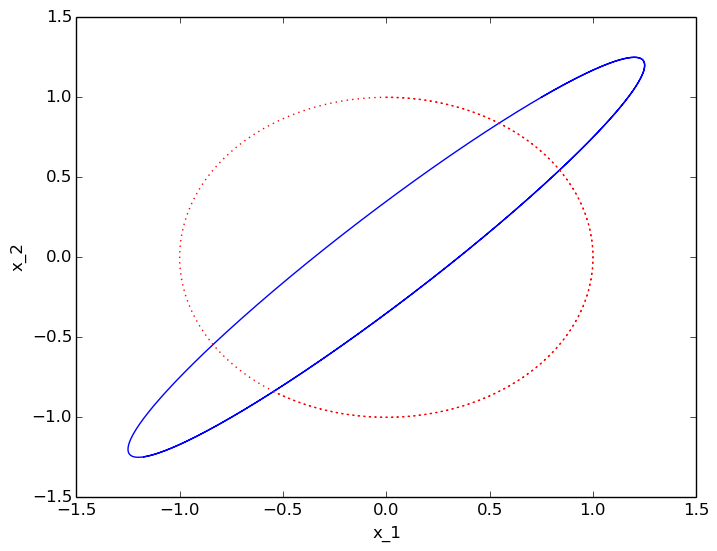

PyObject <matplotlib.text.Text object at 0x7fe041858ed0>

In [82]:
d = 0.75
A = [1 d;d 1]
t = 0:.01:10; m = length(t);
x = zeros(2,m)
x[1,1:m] = sin(t);
x[2,1:m] = cos(t);
y = A*x;
plot(vec(y[1,:]),vec(y[2,:]),"b-",vec(x[1,:]),vec(x[2,:]),"r:")
xlabel("x_1")
ylabel("x_2") 